In [ ]:
!pip -q install gdown
!gdown https://drive.google.com/uc?id=1DHC-e8NlmPiMcI6Ve3xsTat7zI2zkFiT

Downloading...
From: https://drive.google.com/uc?id=1DHC-e8NlmPiMcI6Ve3xsTat7zI2zkFiT
To: /content/pa2_data.zip
100% 201M/201M [00:01<00:00, 152MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('./pa2_data.zip', 'r') as zip_ref:
  zip_ref.extractall('./')

In [ ]:
import os
os.chdir('./pa2_data')

In [ ]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
import os.path as osp
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [ ]:
df_v = pd.read_csv('./val/gt.csv', sep=',')
df_v

,query,gallery
0,val/query/1.jpg,val/gallery/1.jpg
1,val/query/2.jpg,val/gallery/2.jpg
2,val/query/3.jpg,val/gallery/3.jpg
3,val/query/4.jpg,val/gallery/4.jpg
4,val/query/5.jpg,val/gallery/5.jpg
5,val/query/6.jpg,val/gallery/6.jpg
6,val/query/7.jpg,val/gallery/7.jpg
7,val/query/8.jpg,val/gallery/8.jpg
8,val/query/9.jpg,val/gallery/9.jpg
9,val/query/10.jpg,val/gallery/10.jpg


In [ ]:
class ZeroPadding(torch.nn.Module):

    def __init__(self):
        super(ZeroPadding, self).__init__()

    def forward(self, img):
        new_width = int(128 * img.shape[2]/img.shape[1])
        transform = T.Resize(size=(128, new_width))
        resized_image = transform(img)
        crop = T.CenterCrop(128)
        resized_image = crop(resized_image)
        return resized_image

In [ ]:
class RetrievalDataset(Dataset):
    
    def __init__(self, csv_file, image_dir, phase):
        self.df = pd.read_csv(csv_file)
        self.query = self.df['query'].to_numpy()
        if phase == 'train':
            self.gallery = self.df['gallery'].to_numpy()
            self.phase = 'train'
        else:
            self.phase = 'test'
        self.image = image_dir
        self.transform = T.Compose([T.ToTensor(),
                                    ZeroPadding(),
                                    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                    ])
        
    def get_gallery_imgs(self):
        imgs = []
        # for i in os.listdir('./val/gallery'):
        #     image = Image.open(os.path.join('./val/gallery', i))

        #     if self.transform is not None:
        #         image = self.transform(image)
                
        #     imgs.append(image)
            
        # return torch.stack(imgs)
        for i in range(len(self.gallery)):
          image = Image.open(self.gallery[i])
          
          if self.transform is not None:
            image = self.transform(image)
          imgs.append(image)
        return torch.stack(imgs)


    def __getitem__(self, idx):
        img_name = os.path.join(self.image, self.query[idx])
        image = Image.open(img_name)
        if self.transform is not None:
            
            image = self.transform(image)
        
        return image, idx

    def __len__(self):
        return len(self.df)

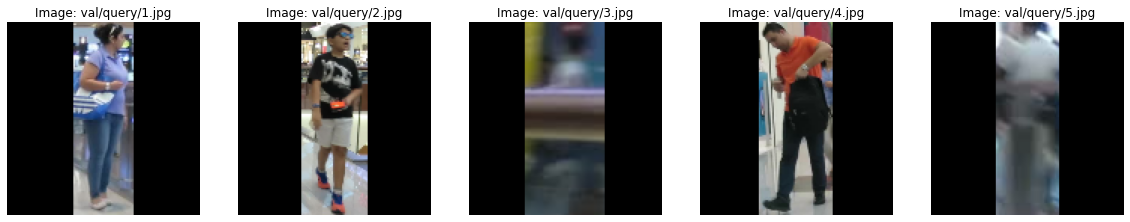

In [ ]:
ret_dataset = RetrievalDataset('./val/gt.csv', './', 'train')

fig = plt.figure(figsize=(20,10))
for i in range(len(ret_dataset)):
    image,idx = ret_dataset[i]
    ax = plt.subplot(1, 5, i + 1)
    ax.set_title('Image: {}'.format(ret_dataset.query[idx]))
    ax.axis('off')
    image[0] = (image[0] * 0.229 + 0.485)
    image[1] = (image[1] * 0.224 + 0.456)
    image[2] = (image[2] * 0.225 + 0.406)
    plt.imshow(np.transpose(image, (1,2,0)))
    if i == 4:
        plt.show()
        break

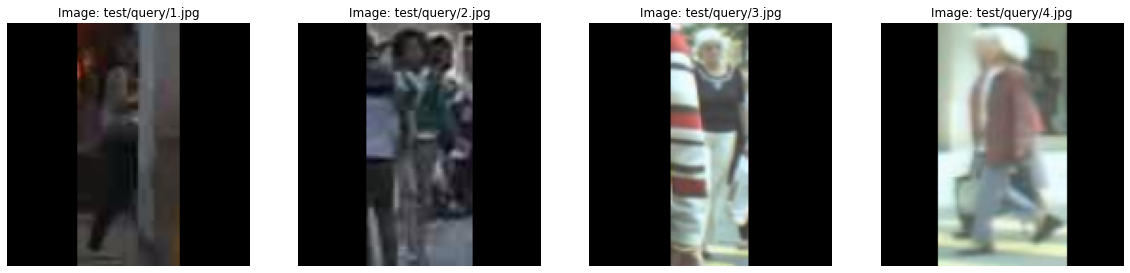

In [ ]:
test_dataset = RetrievalDataset('./test/pred.csv', './', 'test')

fig = plt.figure(figsize=(20,10))
for i in range(len(test_dataset)):
    image,idx = test_dataset[i]
    ax = plt.subplot(1, 4, i + 1)
    ax.set_title('Image: {}'.format(test_dataset.query[idx]))
    ax.axis('off')
    image[0] = (image[0] * 0.229 + 0.485)
    image[1] = (image[1] * 0.224 + 0.456)
    image[2] = (image[2] * 0.225 + 0.406)
    plt.imshow(np.transpose(image, (1,2,0)))
    if i == 3:
        plt.show()
        break

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



NameError: ignored

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_D=False):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.Layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2 if is_D else 1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.Layer2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.Residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if is_D else 1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else nn.Identity()
            
    def forward(self, x):
        out = self.Layer1(x)
        out = self.Layer2(out)
        if self.in_channels != self.out_channels:
            x = self.Residual(x)
        out += x
        out = F.relu(out)
        
        return out

In [ ]:
class ResNet_18(nn.Module):
    def __init__(self):
        super(ResNet_18, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.RB1 = ResBlock(64,64)
        self.RB2 = ResBlock(64,64)
        self.RB3 = ResBlock(64,128,True)
        self.RB4 = ResBlock(128,128)
        self.RB5 = ResBlock(128,256,True)
        self.RB6 = ResBlock(256,256)
        self.RB7 = ResBlock(256,512)
        self.RB8 = ResBlock(512,512)
        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)
    
    def forward(self, x):
        return self.avg_pool(self.RB8(self.RB7(self.RB6(self.RB5(self.RB4(self.RB3(self.RB2(self.RB1(self.max_pool(self.conv1(x)))))))))))



In [ ]:
from torchsummary import summary
model = ResNet_18().to('cuda')
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
         ResBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch.utils.model_zoo as model_zoo
url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
pretrain_dict = model_zoo.load_url(url)
model.load_state_dict(pretrain_dict, strict=False)

_IncompatibleKeys(missing_keys=['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'RB1.Layer1.0.weight', 'RB1.Layer1.1.weight', 'RB1.Layer1.1.bias', 'RB1.Layer1.1.running_mean', 'RB1.Layer1.1.running_var', 'RB1.Layer2.0.weight', 'RB1.Layer2.1.weight', 'RB1.Layer2.1.bias', 'RB1.Layer2.1.running_mean', 'RB1.Layer2.1.running_var', 'RB2.Layer1.0.weight', 'RB2.Layer1.1.weight', 'RB2.Layer1.1.bias', 'RB2.Layer1.1.running_mean', 'RB2.Layer1.1.running_var', 'RB2.Layer2.0.weight', 'RB2.Layer2.1.weight', 'RB2.Layer2.1.bias', 'RB2.Layer2.1.running_mean', 'RB2.Layer2.1.running_var', 'RB3.Layer1.0.weight', 'RB3.Layer1.1.weight', 'RB3.Layer1.1.bias', 'RB3.Layer1.1.running_mean', 'RB3.Layer1.1.running_var', 'RB3.Layer2.0.weight', 'RB3.Layer2.1.weight', 'RB3.Layer2.1.bias', 'RB3.Layer2.1.running_mean', 'RB3.Layer2.1.running_var', 'RB3.Residual.0.weight', 'RB3.Residual.1.weight', 'RB3.Residual.1.bias', 'RB3.Residual.1.running_mean', 'RB3.Residual.1.runni

In [ ]:
class fcs(nn.Module):
    def __init__(self):
        super(fcs, self).__init__()
        self.ResNet = ResNet_18()
        self.ResNet.load_state_dict(pretrain_dict, strict=False)
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc3 = nn.Linear(256,230)
        self.fc3_v = nn.Linear(256,49)
    def forward(self, x):
      return self.fc2(self.ResNet(x).view(x.shape[0], 512))
    
    def forward2(self, x, phase):
      if(phase == 'train'):
        return self.fc3(self.fc2(self.ResNet(x).view(x.shape[0],512)))
      else:
        return self.fc3_v(self.fc2(self.ResNet(x).view(x.shape[0],512)))

In [ ]:
df_tl = pd.read_csv('./train_idloss.csv', sep=',')
df_vl = pd.read_csv('./val_idloss.csv', sep=',')
df_tl
#df_vl

,filepath,id
0,imgs/train/0/1.jpg,0
1,imgs/train/0/2.jpg,0
2,imgs/train/0/3.jpg,0
3,imgs/train/0/4.jpg,0
4,imgs/train/0/5.jpg,0
...,...,...
2295,imgs/train/229/6.jpg,229
2296,imgs/train/229/7.jpg,229
2297,imgs/train/229/8.jpg,229
2298,imgs/train/229/9.jpg,229


In [ ]:
class IDLossDataset(Dataset):

    def __init__(self, csv_file, image_dir, phase):
        self.df = pd.read_csv(csv_file)
        self.filepath = self.df['filepath'].to_numpy()
        self.id = self.df['id']
        self.image = image_dir
        if phase == 'train':
            self.phase = 'train'
            self.transform_t = T.Compose([T.ToTensor(),
                                          T.RandomHorizontalFlip(p=0.5),
                                          T.RandomErasing(p=0.5, scale=(0.05, 0.2)),
                                          ZeroPadding(),
                                          T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                         ])
        else:
            self.phase = 'test'
            self.transform = T.Compose([T.ToTensor(),
                                        ZeroPadding(),
                                        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                        ])
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.image, self.filepath[idx])
        image = Image.open(img_name)

        if self.phase == 'train':
            
            if self.transform_t is not None:
                
                image = self.transform_t(image)
                 
        else:
            
            if self.transform is not None:
            
                image = self.transform(image)
        
        return image, self.id[idx]

    
    
    def __len__(self):
        return len(self.df)

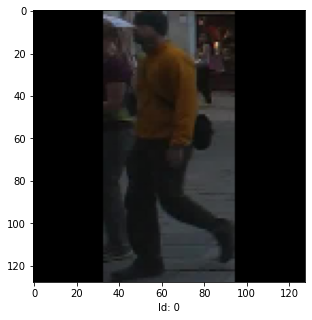

In [ ]:
train_IDLoss_dataset = IDLossDataset('./train_idloss.csv', './', 'train')
fig = plt.figure(figsize=(5,5))
image,idx = train_IDLoss_dataset[0]
plt.xlabel('Id: {}'.format(train_IDLoss_dataset.id[0])) 
image[0] = (image[0] * 0.229 + 0.485)
image[1] = (image[1] * 0.224 + 0.456)
image[2] = (image[2] * 0.225 + 0.406)
plt.imshow(np.transpose(image, (1,2,0)))
plt.show()

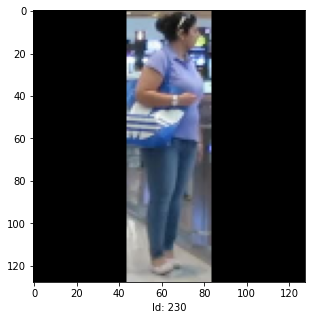

In [ ]:
val_IDLoss_dataset = IDLossDataset('./val_idloss.csv', './', 'val')
fig = plt.figure(figsize=(5,5))
image, idx = val_IDLoss_dataset[0]
plt.xlabel('Id: {}'.format(val_IDLoss_dataset.id[0]))
image[0] = (image[0] * 0.229 + 0.485)
image[1] = (image[1] * 0.224 + 0.456)
image[2] = (image[2] * 0.225 + 0.406)
plt.imshow(np.transpose(image, (1,2,0)))
plt.show()

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
def train_model(loaded_model, train_IDLoss_loader, valid_IDLoss_loader, ret_loader, num_epochs, criterion, optimizer, device):
    best_val_loss = float("Inf")
    r1_l = []
    r5_l = []
    r10_l = []
    train_loss_l = []
    train_loss_i_l = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        ## Train phase
        running_loss = 0.0
        running_corrects = 0
        r1 = 0
        r5 = 0
        r10 = 0
        loaded_model.train()
        for inputs, labels in tqdm(train_IDLoss_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = loaded_model.forward2(inputs, 'train') ## step 1.
            loss = criterion(outputs, labels) ## step 2.
            optimizer.zero_grad() ## clear the previous gradients 
            loss.backward() ## step 3. backpropagation - compute gradient
            optimizer.step() ## step 4. w = w - eta*w.grad
            running_loss += loss.item()
            train_loss_i_l.append(loss.item())
            _, preds = torch.max(outputs.data, 1) 
            running_corrects += torch.sum(preds == labels.data)  ## step 2 - measure accuracy
        ## train epoch loss and accuracy
        train_loss = running_loss / len(train_IDLoss_loader)
        train_acc = running_corrects / float(len(train_IDLoss_loader.dataset))
        ## Validation phase
        with torch.no_grad():
            loaded_model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(valid_IDLoss_loader):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = loaded_model.forward2(inputs,'val') ## step 1
              labels -= 230
              loss = criterion(outputs, labels) ## step 2 - loss
              running_loss += loss.item()

              _, preds = torch.max(outputs.data, 1)
              running_corrects += torch.sum(preds == labels.data) ## step 2 - measure accuracy
              ## validation epoch loss and accuracy
            valid_loss = running_loss / len(validIDLoss_loader)
            valid_acc = running_corrects / float(len(valid_IDLoss_loader.dataset))
            all_img = ret_dataset.get_gallery_imgs().to(device)
            feature_gal = loaded_model(all_img)
            for inputs, idx in ret_loader:
              inputs, idx = inputs.to(device), idx.to(device)
              feature = loaded_model(inputs)
              for id, row in enumerate(feature):
                sim = nn.CosineSimilarity()(row.unsqueeze(0), feature_gal)
                _, preds = torch.topk (sim, 10, 0)
                if idx[id] in preds[:1]:
                  r1 += 1
                if idx[id] in preds[:5]:
                  r5 += 1
                if idx[id] in preds[:10]:
                  r10 += 1
            print(len(ret_loader.dataset))
            r1_l.append(r1 / float(len(ret_loader.dataset)))
            r5_l.append(r5 / float(len(ret_loader.dataset)))
            r10_l.append(r10 / float(len(ret_loader.dataset)))
            train_loss_l.append(train_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))


    print('Finished Training')
    return r1_l, r5_l, r10_l, train_loss_l, train_loss_i_l

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = fcs().to(device)
loaded_model.train()
ret_loader = DataLoader(ret_dataset, batch_size=49, shuffle=False, drop_last=True)
train_IDLoss_loader = DataLoader(train_IDLoss_dataset, batch_size=128, shuffle=False, drop_last=True)
val_IDLoss_loader = DataLoader(val_IDLoss_dataset, batch_size=128, shuffle=False, drop_last=True)
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(loaded_model.parameters(), lr=0.001)
r1_l, r5_l, r10_l, train_loss_l, train_loss_i_l = train_model(loaded_model, train_IDLoss_loader, val_IDLoss_loader, ret_loader, num_epochs, criterion, optimizer, device)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [1/50], Train Loss: 5.7791, Train Acc: 0.0000, Valid Loss: 4.5577,  Valid Acc: 0.0449


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [2/50], Train Loss: 5.4099, Train Acc: 0.0078, Valid Loss: 14.7954,  Valid Acc: 0.0245


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [3/50], Train Loss: 5.2122, Train Acc: 0.0078, Valid Loss: 7.4638,  Valid Acc: 0.0020


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [4/50], Train Loss: 5.0982, Train Acc: 0.0087, Valid Loss: 4.8386,  Valid Acc: 0.0020


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [5/50], Train Loss: 4.9738, Train Acc: 0.0087, Valid Loss: 3.9888,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [6/50], Train Loss: 4.8728, Train Acc: 0.0165, Valid Loss: 3.8621,  Valid Acc: 0.0327


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [7/50], Train Loss: 4.7402, Train Acc: 0.0222, Valid Loss: 3.8719,  Valid Acc: 0.0306


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [8/50], Train Loss: 4.6163, Train Acc: 0.0309, Valid Loss: 3.8835,  Valid Acc: 0.0388


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [9/50], Train Loss: 4.4630, Train Acc: 0.0491, Valid Loss: 3.9169,  Valid Acc: 0.0327


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [10/50], Train Loss: 4.3700, Train Acc: 0.0517, Valid Loss: 3.9696,  Valid Acc: 0.0429


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [11/50], Train Loss: 4.2910, Train Acc: 0.0604, Valid Loss: 4.0984,  Valid Acc: 0.0204


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [12/50], Train Loss: 4.2401, Train Acc: 0.0609, Valid Loss: 4.7388,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [13/50], Train Loss: 4.1713, Train Acc: 0.0722, Valid Loss: 4.8564,  Valid Acc: 0.0082


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [14/50], Train Loss: 4.0785, Train Acc: 0.0935, Valid Loss: 4.2076,  Valid Acc: 0.0061


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [15/50], Train Loss: 3.9801, Train Acc: 0.1017, Valid Loss: 3.9792,  Valid Acc: 0.0163


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [16/50], Train Loss: 3.7764, Train Acc: 0.1404, Valid Loss: 3.9164,  Valid Acc: 0.0204


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [17/50], Train Loss: 3.6438, Train Acc: 0.1817, Valid Loss: 3.8969,  Valid Acc: 0.0245


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [18/50], Train Loss: 3.5367, Train Acc: 0.2004, Valid Loss: 3.9357,  Valid Acc: 0.0245


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [19/50], Train Loss: 3.4390, Train Acc: 0.2204, Valid Loss: 3.9566,  Valid Acc: 0.0327


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [20/50], Train Loss: 3.3782, Train Acc: 0.2196, Valid Loss: 3.8469,  Valid Acc: 0.0286


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [21/50], Train Loss: 3.3631, Train Acc: 0.2091, Valid Loss: 3.9543,  Valid Acc: 0.0061


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [22/50], Train Loss: 3.1749, Train Acc: 0.2613, Valid Loss: 4.0011,  Valid Acc: 0.0082


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [23/50], Train Loss: 2.9953, Train Acc: 0.3126, Valid Loss: 3.9777,  Valid Acc: 0.0204


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [24/50], Train Loss: 2.8646, Train Acc: 0.3483, Valid Loss: 3.9244,  Valid Acc: 0.0082


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [25/50], Train Loss: 2.7307, Train Acc: 0.3830, Valid Loss: 3.9098,  Valid Acc: 0.0204


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [26/50], Train Loss: 2.6297, Train Acc: 0.4026, Valid Loss: 3.9703,  Valid Acc: 0.0347


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [27/50], Train Loss: 2.5773, Train Acc: 0.3917, Valid Loss: 4.0475,  Valid Acc: 0.0102


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [28/50], Train Loss: 2.4936, Train Acc: 0.4143, Valid Loss: 3.9579,  Valid Acc: 0.0265


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [29/50], Train Loss: 2.3979, Train Acc: 0.4348, Valid Loss: 3.9377,  Valid Acc: 0.0531


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [30/50], Train Loss: 2.3590, Train Acc: 0.4339, Valid Loss: 4.2596,  Valid Acc: 0.0163


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [31/50], Train Loss: 2.2823, Train Acc: 0.4491, Valid Loss: 3.9331,  Valid Acc: 0.0245


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [32/50], Train Loss: 2.1502, Train Acc: 0.4957, Valid Loss: 3.9012,  Valid Acc: 0.0429


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [33/50], Train Loss: 1.9907, Train Acc: 0.5409, Valid Loss: 4.0208,  Valid Acc: 0.0143


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [34/50], Train Loss: 1.8854, Train Acc: 0.5522, Valid Loss: 3.8926,  Valid Acc: 0.0265


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [35/50], Train Loss: 1.7935, Train Acc: 0.5839, Valid Loss: 3.9380,  Valid Acc: 0.0408


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [36/50], Train Loss: 1.6722, Train Acc: 0.6122, Valid Loss: 4.0233,  Valid Acc: 0.0224


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [37/50], Train Loss: 1.6009, Train Acc: 0.6109, Valid Loss: 3.9223,  Valid Acc: 0.0388


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [38/50], Train Loss: 1.4754, Train Acc: 0.6513, Valid Loss: 3.9325,  Valid Acc: 0.0367


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [39/50], Train Loss: 1.3718, Train Acc: 0.6804, Valid Loss: 4.0065,  Valid Acc: 0.0184


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [40/50], Train Loss: 1.2214, Train Acc: 0.7309, Valid Loss: 3.9293,  Valid Acc: 0.0286


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [41/50], Train Loss: 1.1931, Train Acc: 0.7204, Valid Loss: 4.1168,  Valid Acc: 0.0367


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [42/50], Train Loss: 1.1595, Train Acc: 0.7309, Valid Loss: 3.9575,  Valid Acc: 0.0102


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [43/50], Train Loss: 1.1670, Train Acc: 0.7161, Valid Loss: 3.9876,  Valid Acc: 0.0306


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [44/50], Train Loss: 1.1494, Train Acc: 0.7187, Valid Loss: 4.3120,  Valid Acc: 0.0286


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [45/50], Train Loss: 1.1481, Train Acc: 0.7104, Valid Loss: 4.1314,  Valid Acc: 0.0041


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [46/50], Train Loss: 1.1102, Train Acc: 0.7200, Valid Loss: 3.9638,  Valid Acc: 0.0265


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [47/50], Train Loss: 0.9911, Train Acc: 0.7504, Valid Loss: 3.9715,  Valid Acc: 0.0571


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [48/50], Train Loss: 0.9019, Train Acc: 0.7683, Valid Loss: 4.0282,  Valid Acc: 0.0469


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [49/50], Train Loss: 0.7659, Train Acc: 0.8109, Valid Loss: 4.1004,  Valid Acc: 0.0367


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [50/50], Train Loss: 0.6555, Train Acc: 0.8296, Valid Loss: 4.1785,  Valid Acc: 0.0265
Finished Training


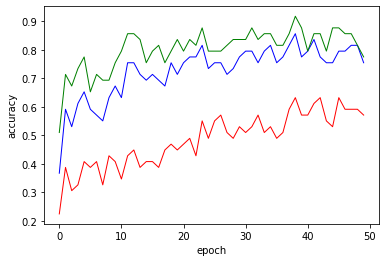

In [ ]:
H = [i for i in range(0, num_epochs)]
plt.plot(H, r1_l, color='red', linewidth=1, label='r1 over Rk')
plt.plot(H, r5_l, color='blue', linewidth=1, label='r5 over Rk')
plt.plot(H, r10_l, color='green', linewidth=1, label='r10 over Rk')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
print(r1_l[-1])
print(r5_l[-1])
print(r10_l[-1])

0.5714285714285714
0.7551020408163265
0.7755102040816326


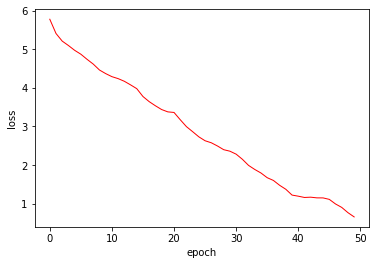

In [ ]:
H = [i for i in range(0, num_epochs)]
plt.plot(H, train_loss_l, color='red', linewidth=1, label='training loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

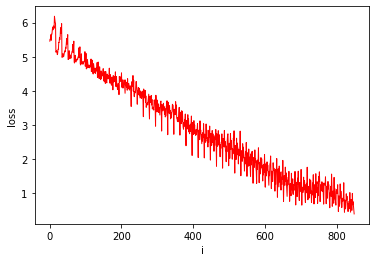

In [ ]:
H = [i for i in range(len(train_loss_i_l))]
plt.plot(H, train_loss_i_l, color='red', linewidth=1, label='training loss per iteration')
plt.xlabel('i')
plt.ylabel('loss')
plt.show()

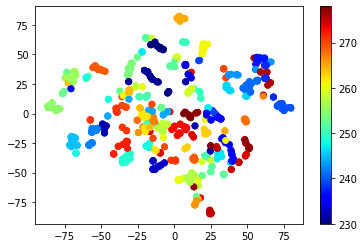

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
def show_2D_tSNE(v, target):
    v = v
    v_reduced = TSNE(n_components=2, random_state=20714566, perplexity=10).fit_transform(v)
    plt.scatter(v_reduced[:, 0], v_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()
val_IDLoss_loader = DataLoader(val_IDLoss_dataset, batch_size=128, shuffle=False, drop_last=True)
raw_x = np.array([x.numpy() for x, y in val_IDLoss_loader.dataset])
raw_y = np.array([y for x, y in val_IDLoss_loader.dataset])
raw_x = raw_x.reshape((len(raw_x), -1))
if True:
    LIMIT = 1000
    chosen_idxes = np.random.choice(list(range(len(raw_x))), LIMIT)
    raw_x = raw_x[chosen_idxes]
    raw_y = raw_y[chosen_idxes]

show_2D_tSNE(raw_x, raw_y)

In [ ]:
class newNet(nn.Module):
    def __init__(self):
        super(newNet, self).__init__()
        self.ResNet = ResNet_18()
        self.ResNet.load_state_dict(pretrain_dict, strict=False)
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc3 = nn.Linear(256,256)

    def forward(self, x):
      return self.fc3(self.fc2(self.ResNet(x).view(x.shape[0], 512)))

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
def train_model2(loaded_model, train_IDLoss_loader, valid_IDLoss_loader, ret_loader, num_epochs, criterion, optimizer, device):
    best_val_loss = float("Inf")
    r1_l = []
    r5_l = []
    r10_l = []
    train_loss_l = []
    train_loss_i_l = []
    valid_acc_l = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        ## Train phase
        running_loss = 0.0
        running_corrects = 0
        r1 = 0
        r5 = 0
        r10 = 0
        loaded_model.train()
        for inputs, labels in tqdm(train_IDLoss_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = loaded_model(inputs) ## step 1.
            loss = criterion(outputs, labels) ## step 2.
            optimizer.zero_grad() ## clear the previous gradients 
            loss.backward() ## step 3. backpropagation - compute gradient
            optimizer.step() ## step 4. w = w - eta*w.grad
            running_loss += loss.item()
            train_loss_i_l.append(loss.item())
            _, preds = torch.max(outputs.data, 1) 
            running_corrects += torch.sum(preds == labels.data)  ## step 2 - measure accuracy
        ## train epoch loss and accuracy
        train_loss = running_loss / len(train_IDLoss_loader)
        train_acc = running_corrects / float(len(train_IDLoss_loader.dataset))
        ## Validation phase
        with torch.no_grad():
            loaded_model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(valid_IDLoss_loader):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = loaded_model(inputs) ## step 1
              labels -= 230
              loss = criterion(outputs, labels) ## step 2 - loss
              running_loss += loss.item()

              _, preds = torch.max(outputs.data, 1)
              running_corrects += torch.sum(preds == labels.data) ## step 2 - measure accuracy
              ## validation epoch loss and accuracy
            valid_loss = running_loss / len(valid_IDLoss_loader)
            valid_acc = running_corrects / float(len(valid_IDLoss_loader.dataset))
            all_img = ret_dataset.get_gallery_imgs().to(device)
            feature_gal = loaded_model(all_img)
            for inputs, idx in ret_loader:
              inputs, idx = inputs.to(device), idx.to(device)
              feature = loaded_model(inputs)
              for id, row in enumerate(feature):
                sim = nn.CosineSimilarity()(row.unsqueeze(0), feature_gal)
                _, preds = torch.topk (sim, 10, 0)
                if idx[id] in preds[:1]:
                  r1 += 1
                if idx[id] in preds[:5]:
                  r5 += 1
                if idx[id] in preds[:10]:
                  r10 += 1
            print(len(ret_loader.dataset))
            r1_l.append(r1 / float(len(ret_loader.dataset)))
            r5_l.append(r5 / float(len(ret_loader.dataset)))
            r10_l.append(r10 / float(len(ret_loader.dataset)))
            train_loss_l.append(train_loss)
            valid_acc_l.append(valid_acc)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))


    print('Finished Training')
    return r1_l, r5_l, r10_l, train_loss_l, valid_acc_l

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = newNet().to(device)
loaded_model.train()
ret_loader = DataLoader(ret_dataset, batch_size=49, shuffle=False, drop_last=True)
train_IDLoss_loader = DataLoader(train_IDLoss_dataset, batch_size=128, shuffle=False, drop_last=True)
val_IDLoss_loader = DataLoader(val_IDLoss_dataset, batch_size=128, shuffle=False, drop_last=True)
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(loaded_model.parameters(), lr=0.00001)
r1_l, r5_l, r10_l, train_loss_l, valid_acc_l = train_model2(loaded_model, train_IDLoss_loader, val_IDLoss_loader, ret_loader, num_epochs, criterion, optimizer, device)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [1/30], Train Loss: 5.6643, Train Acc: 0.0017, Valid Loss: 5.5373,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [2/30], Train Loss: 5.5353, Train Acc: 0.0030, Valid Loss: 5.5742,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [3/30], Train Loss: 5.4587, Train Acc: 0.0104, Valid Loss: 5.6109,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [4/30], Train Loss: 5.3908, Train Acc: 0.0122, Valid Loss: 5.6330,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [5/30], Train Loss: 5.3149, Train Acc: 0.0265, Valid Loss: 5.6273,  Valid Acc: 0.0041


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [6/30], Train Loss: 5.2578, Train Acc: 0.0343, Valid Loss: 5.6358,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [7/30], Train Loss: 5.1958, Train Acc: 0.0465, Valid Loss: 5.6207,  Valid Acc: 0.0041


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [8/30], Train Loss: 5.1539, Train Acc: 0.0609, Valid Loss: 5.6221,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [9/30], Train Loss: 5.0958, Train Acc: 0.0709, Valid Loss: 5.6072,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [10/30], Train Loss: 5.0630, Train Acc: 0.0883, Valid Loss: 5.5908,  Valid Acc: 0.0020


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [11/30], Train Loss: 5.0079, Train Acc: 0.1074, Valid Loss: 5.6200,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [12/30], Train Loss: 4.9478, Train Acc: 0.1287, Valid Loss: 5.6332,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [13/30], Train Loss: 4.9148, Train Acc: 0.1487, Valid Loss: 5.6178,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [14/30], Train Loss: 4.8547, Train Acc: 0.1548, Valid Loss: 5.5787,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [15/30], Train Loss: 4.8346, Train Acc: 0.1739, Valid Loss: 5.6221,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [16/30], Train Loss: 4.7835, Train Acc: 0.2126, Valid Loss: 5.5957,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [17/30], Train Loss: 4.7437, Train Acc: 0.2117, Valid Loss: 5.6067,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [18/30], Train Loss: 4.7071, Train Acc: 0.2513, Valid Loss: 5.5981,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [19/30], Train Loss: 4.6676, Train Acc: 0.2591, Valid Loss: 5.5778,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [20/30], Train Loss: 4.6359, Train Acc: 0.2887, Valid Loss: 5.5862,  Valid Acc: 0.0020


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [21/30], Train Loss: 4.5884, Train Acc: 0.3213, Valid Loss: 5.6087,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [22/30], Train Loss: 4.5552, Train Acc: 0.3287, Valid Loss: 5.5795,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [23/30], Train Loss: 4.5227, Train Acc: 0.3539, Valid Loss: 5.5784,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [24/30], Train Loss: 4.4851, Train Acc: 0.3609, Valid Loss: 5.5952,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [25/30], Train Loss: 4.4399, Train Acc: 0.3983, Valid Loss: 5.5573,  Valid Acc: 0.0041


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [26/30], Train Loss: 4.4252, Train Acc: 0.3965, Valid Loss: 5.5712,  Valid Acc: 0.0000


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [27/30], Train Loss: 4.3744, Train Acc: 0.4439, Valid Loss: 5.5707,  Valid Acc: 0.0020


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [28/30], Train Loss: 4.3377, Train Acc: 0.4483, Valid Loss: 5.5921,  Valid Acc: 0.0020


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [29/30], Train Loss: 4.3154, Train Acc: 0.4626, Valid Loss: 5.5784,  Valid Acc: 0.0061


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

49
Epoch [30/30], Train Loss: 4.2816, Train Acc: 0.4743, Valid Loss: 5.5592,  Valid Acc: 0.0061
Finished Training


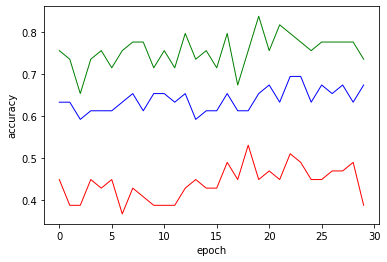

In [ ]:
H = [i for i in range(0, num_epochs)]
plt.plot(H, r1_l, color='red', linewidth=1, label='r1 over Rk')
plt.plot(H, r5_l, color='blue', linewidth=1, label='r5 over Rk')
plt.plot(H, r10_l, color='green', linewidth=1, label='r10 over Rk')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
print(r1_l[-1])
print(r5_l[-1])
print(r10_l[-1])

0.3877551020408163
0.673469387755102
0.7346938775510204


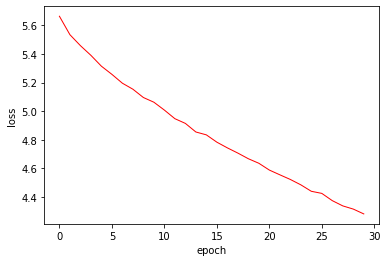

In [ ]:
H = [i for i in range(0, num_epochs)]
plt.plot(H, train_loss_l, color='red', linewidth=1, label='training loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

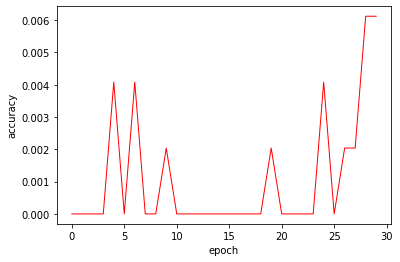

In [ ]:
H = [i for i in range(len(valid_acc_l))]
plt.plot(H, valid_acc_l, color='red', linewidth=1, label='validation accuracy per epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()